In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = ""  
db_port = "" 
db_name = ""
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [3]:
provincia = '08|033%'
escluso ='08|033|032%' # comune escluso

In [4]:
query= text(""" SELECT 
  date,
  SUM(ingressi) AS ingressi,
  SUM(uscite) AS uscite 
FROM ( 
  SELECT
    datefrom AS date,
    datavalue AS ingressi,
    0 AS uscite
  FROM movements
  WHERE toid LIKE '""" + provincia + """' AND toid NOT LIKE '""" + escluso + """'

  UNION ALL

  SELECT
    datefrom AS date,
    0 AS ingressi,
    datavalue AS uscite
  FROM movements
   WHERE layerid LIKE '""" + provincia + """' AND toid NOT LIKE '""" + escluso + """'
) AS movimenti
GROUP BY date
ORDER BY date; 
""")

try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True)  
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

                    date  ingressi  uscite
0    2019-08-01 00:00:00      7097    7859
1    2019-08-01 01:00:00      2917    3146
2    2019-08-01 02:00:00      2329    2424
3    2019-08-01 03:00:00      2263    2403
4    2019-08-01 04:00:00      3137    3538
...                  ...       ...     ...
1459 2019-09-30 19:00:00     13871   13874
1460 2019-09-30 20:00:00      9579    9716
1461 2019-09-30 21:00:00      6366    6389
1462 2019-09-30 22:00:00      3448    3571
1463 2019-09-30 23:00:00      1397    1478

[1464 rows x 3 columns]


In [5]:
#togliamo righe dove sono presenti 0 e calcoliamo flusso
df = df[(df['ingressi'] != 0) & (df['uscite'] != 0)]
df['flusso'] = df['ingressi'] - df['uscite']
df

,date,ingressi,uscite,flusso
0,2019-08-01 00:00:00,7097,7859,-762
1,2019-08-01 01:00:00,2917,3146,-229
2,2019-08-01 02:00:00,2329,2424,-95
3,2019-08-01 03:00:00,2263,2403,-140
4,2019-08-01 04:00:00,3137,3538,-401
...,...,...,...,...
1459,2019-09-30 19:00:00,13871,13874,-3
1460,2019-09-30 20:00:00,9579,9716,-137
1461,2019-09-30 21:00:00,6366,6389,-23
1462,2019-09-30 22:00:00,3448,3571,-123


In [6]:
mean = df['flusso'].mean()
std = df['flusso'].std()

# Calcolo z-score
df['z_score'] = (df['flusso'] - mean) / std
df

,date,ingressi,uscite,flusso,z_score
0,2019-08-01 00:00:00,7097,7859,-762,-0.989507
1,2019-08-01 01:00:00,2917,3146,-229,0.353058
2,2019-08-01 02:00:00,2329,2424,-95,0.690589
3,2019-08-01 03:00:00,2263,2403,-140,0.577239
4,2019-08-01 04:00:00,3137,3538,-401,-0.080190
...,...,...,...,...,...
1459,2019-09-30 19:00:00,13871,13874,-3,0.922326
1460,2019-09-30 20:00:00,9579,9716,-137,0.584796
1461,2019-09-30 21:00:00,6366,6389,-23,0.871949
1462,2019-09-30 22:00:00,3448,3571,-123,0.620060


In [7]:
#vediamo giorni anomali
eventi = df[df['z_score'].abs() > 3]
print(eventi)

                    date  ingressi  uscite  flusso   z_score
7    2019-08-01 07:00:00     15037   16893   -1856 -3.745166
8    2019-08-01 08:00:00     14031   16498   -2467 -5.284205
9    2019-08-01 09:00:00     13104   15369   -2265 -4.775390
10   2019-08-01 10:00:00     13889   15487   -1598 -3.095294
12   2019-08-01 12:00:00     13627   15431   -1804 -3.614184
13   2019-08-01 13:00:00     14330   16771   -2441 -5.218714
14   2019-08-01 14:00:00     12471   14080   -1609 -3.123002
54   2019-08-03 06:00:00      7098    8725   -1627 -3.168342
55   2019-08-03 07:00:00      9686   11529   -1843 -3.712421
56   2019-08-03 08:00:00     11071   12856   -1785 -3.566326
102  2019-08-05 06:00:00      9312   10933   -1621 -3.153228
103  2019-08-05 07:00:00     14569   16401   -1832 -3.684713
104  2019-08-05 08:00:00     13668   15734   -2066 -4.274132
105  2019-08-05 09:00:00     12951   15017   -2066 -4.274132
109  2019-08-05 13:00:00     14421   16069   -1648 -3.221238
222  2019-08-10 06:00:00

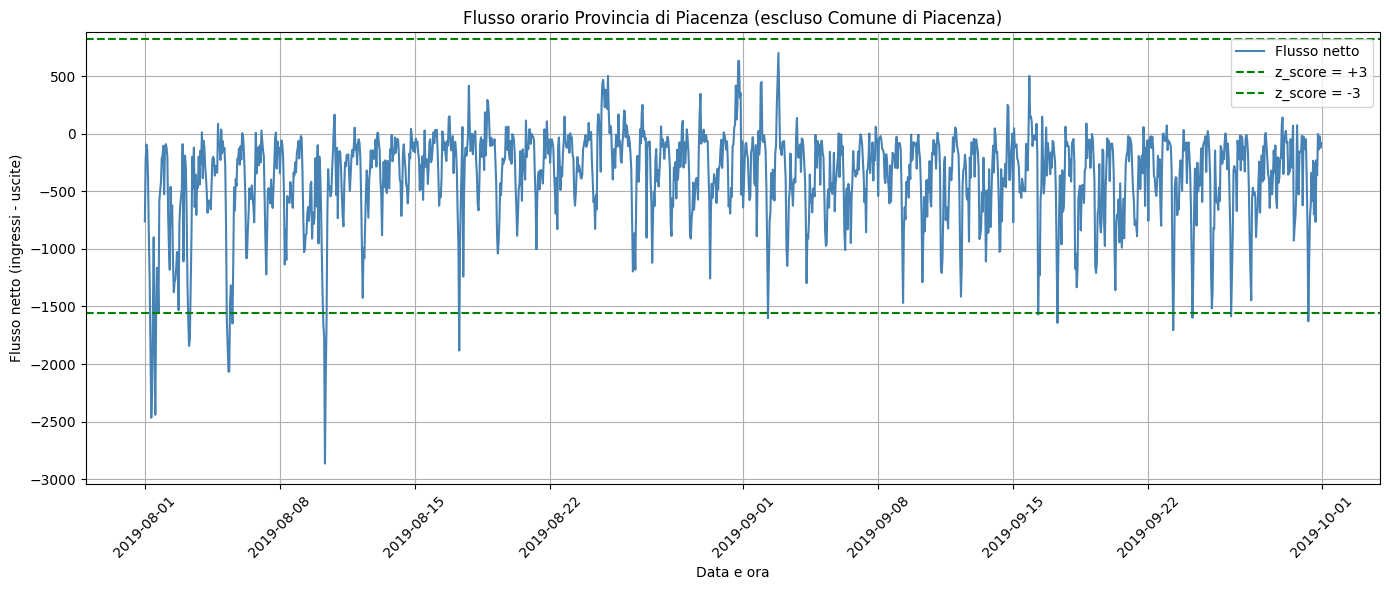

In [8]:
# Grafico del flusso con evidenza dei picchi
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['flusso'], label='Flusso netto', color='steelblue')
#plt.scatter(eventi['date'], eventi['flusso'], color='red', label='Anomalie (|z_score| > 3)', zorder=5)

# Aggiunta delle linee orizzontali per z-score (convertite in scala flusso)
media = df['flusso'].mean()
dev_std = df['flusso'].std()
soglia_pos = media + 3 * dev_std
soglia_neg = media - 3 * dev_std

plt.axhline(soglia_pos, color='green', linestyle='--', label='z_score = +3')
plt.axhline(soglia_neg, color='green', linestyle='--', label='z_score = -3')

# Finalizzazione grafico
plt.title("Flusso orario Provincia di Piacenza (escluso Comune di Piacenza)")
plt.xlabel("Data e ora")
plt.ylabel("Flusso netto (ingressi - uscite)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()